In [820]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from display_config import enable_clean_display
from db_connector import fetch_data

In [821]:
enable_clean_display()  # configures horizontal scrolling for wide DataFrames -- wasn't happening through built-in options

Sales tables, geographical data, and UOM names are in separate schemas, and cross-schema joins are not allowed in PostgreSQL.</br>
So read queries on each schema into their own DataFrames, then merge.

In [822]:
sales_df = fetch_data('''
    SELECT
        il.invoice_line_id,
        il.invoice_id,
        il.stock_item_id,
        il.quantity,
        il.package_type_id,
        il.unit_price,
        il.extended_price,
        o.order_date,
        o.expected_delivery_date,
        i.confirmed_delivery_time,
        c.delivery_city_id
    FROM sales.invoice_lines il
        INNER JOIN sales.invoices i
            ON il.invoice_id = i.invoice_id
        INNER JOIN sales.orders o
            ON i.order_id = o.order_id
        INNER JOIN sales.customers c
            ON o.customer_id = c.customer_id;
''')

print(sales_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228265 entries, 0 to 228264
Data columns (total 11 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   invoice_line_id          228265 non-null  int64         
 1   invoice_id               228265 non-null  int64         
 2   stock_item_id            228265 non-null  int64         
 3   quantity                 228265 non-null  int64         
 4   package_type_id          228265 non-null  int64         
 5   unit_price               228265 non-null  float64       
 6   extended_price           228265 non-null  float64       
 7   order_date               228265 non-null  object        
 8   expected_delivery_date   228265 non-null  object        
 9   confirmed_delivery_time  227981 non-null  datetime64[ns]
 10  delivery_city_id         228265 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(2)
memory usage: 19.2+ MB
N

In [823]:
geo_df = fetch_data('''
    SELECT
        c.city_id,
        c.city_name,
        sp.state_province_code,
        sp.state_province_name,
        sp.sales_territory
    FROM application.cities c
        JOIN application.state_provinces sp
            ON c.state_province_id = sp.state_province_id;
''').rename(columns={
    'state_province_code': 'state_code',
    'state_province_name': 'state_name'
})

print(geo_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37940 entries, 0 to 37939
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   city_id          37940 non-null  int64 
 1   city_name        37940 non-null  object
 2   state_code       37940 non-null  object
 3   state_name       37940 non-null  object
 4   sales_territory  37940 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.4+ MB
None


In [824]:
uom_df = fetch_data('''
    SELECT
        package_type_id,
        package_type_name
    FROM warehouse.package_types;
''')

print(uom_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   package_type_id    14 non-null     int64 
 1   package_type_name  14 non-null     object
dtypes: int64(1), object(1)
memory usage: 356.0+ bytes
None


In [825]:
# The join columns between all 3 tables are the same dtype (int64), so proceed with the merge
df = (pd.merge(sales_df, geo_df, 
    left_on='delivery_city_id',
    right_on='city_id',
    how='inner')
    .drop(columns=['city_id'])
)

df = (pd.merge(df, uom_df,
    left_on='package_type_id',
    right_on='package_type_id',
    how='inner')
)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228265 entries, 0 to 228264
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   invoice_line_id          228265 non-null  int64         
 1   invoice_id               228265 non-null  int64         
 2   stock_item_id            228265 non-null  int64         
 3   quantity                 228265 non-null  int64         
 4   package_type_id          228265 non-null  int64         
 5   unit_price               228265 non-null  float64       
 6   extended_price           228265 non-null  float64       
 7   order_date               228265 non-null  object        
 8   expected_delivery_date   228265 non-null  object        
 9   confirmed_delivery_time  227981 non-null  datetime64[ns]
 10  delivery_city_id         228265 non-null  int64         
 11  city_name                228265 non-null  object        
 12  state_code      

</br>Convert column dtypes where needed:
</br> * All dates and date-times should be 'datetime64'. Opt to use pd.to_datetime() to avoid errors.
</br> * All ID columns should be Pandas 'Int64'.
</br> * All monetary amounts should be 'float64'.
</br> * Suitable categorical columns should be 'category'.
</br>
</br>Set index to the GUID, 'invoice_line_id'.

In [826]:
df['order_date'] = pd.to_datetime(df['order_date'])
df['expected_delivery_date'] = pd.to_datetime(df['expected_delivery_date'])

dtype_dict = {
    'invoice_line_id': 'Int64',
    'invoice_id': 'Int64',
    'stock_item_id': 'Int64',
    'quantity': 'Int64',
    'package_type_id': 'Int64',
    'delivery_city_id': 'Int64',
    'city_name': 'category',
    'state_code': 'category',
    'state_name': 'category',
    'sales_territory': 'category',
    'package_type_name': 'category'
}

df = df.astype(dtype_dict).set_index('invoice_line_id')

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 228265 entries, 1 to 228265
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   invoice_id               228265 non-null  Int64         
 1   stock_item_id            228265 non-null  Int64         
 2   quantity                 228265 non-null  Int64         
 3   package_type_id          228265 non-null  Int64         
 4   unit_price               228265 non-null  float64       
 5   extended_price           228265 non-null  float64       
 6   order_date               228265 non-null  datetime64[ns]
 7   expected_delivery_date   228265 non-null  datetime64[ns]
 8   confirmed_delivery_time  227981 non-null  datetime64[ns]
 9   delivery_city_id         228265 non-null  Int64         
 10  city_name                228265 non-null  category      
 11  state_code               228265 non-null  category      
 12  state_name           

In [827]:
# Check for missing values
df.isna().sum()

invoice_id                   0
stock_item_id                0
quantity                     0
package_type_id              0
unit_price                   0
extended_price               0
order_date                   0
expected_delivery_date       0
confirmed_delivery_time    284
delivery_city_id             0
city_name                    0
state_code                   0
state_name                   0
sales_territory              0
package_type_name            0
dtype: int64

Since I may analyze aspects of the data that don't involve deliveries,</br>
keep all 284 rows with missing datetimes in the base table and filter out in summary table(s).

In [828]:
# Check for duplicates index values
print(df.index.duplicated().sum())

0


In [829]:
# Check for entire duplicate rows, excluding index
print(df.duplicated().sum())

0


In [830]:
# Create date and time metric columns

# Extract date components
df['order_mo'] = df['order_date'].dt.month
df['order_yr'] = df['order_date'].dt.year

# Calculate delivery durations
df['cycle_time_days'] = (
    df['confirmed_delivery_time'] - df['order_date']
    ).dt.days.astype('Int64')

df['delivery_variance_days'] = (
    df['confirmed_delivery_time'] - df['expected_delivery_date']
    ).dt.days.astype('Int64')

In [831]:
# Create order volume metric columns, measured at the invoice/order level

# Calculate a metric for order magnitude
df['total_order_qty'] = df.groupby('invoice_id')['quantity'].transform('sum')

# Calculate a metric for order complexity -- defined as number of lines in an order
df['line_item_count'] = df.groupby('invoice_id')['quantity'].transform('count')

# Calculate the average quantity per line within each order
df['avg_qty_per_line'] = (df['total_order_qty'] / df['line_item_count']).round(2)

In [832]:
# Check for outliers in the key metric columns
print(df[[
    'cycle_time_days', 'delivery_variance_days',
    'total_order_qty', 'line_item_count',
    'avg_qty_per_line'
    ]].describe())

       cycle_time_days  delivery_variance_days  total_order_qty  line_item_count  avg_qty_per_line
count         227981.0                227981.0         228265.0         228265.0          228265.0
mean          2.332563                0.882451       144.210733         3.710998         39.211559
std           21.10116               21.114485       113.511605         1.123506         30.130049
min                1.0                    -2.0              1.0              1.0               1.0
25%                1.0                    -1.0             55.0              3.0              16.0
50%                1.0                     0.0            118.0              4.0             33.25
75%                1.0                     0.0            208.0              5.0              55.0
max             1117.0                  1114.0            854.0              5.0             360.0


Note: Only create an outlier flag if it directly supports answering the initial summary question.  
If it doesn’t help isolate the problem, delete it.

In [838]:
# Create column to flag extremely late deliveries
# Business Logic: Target is 0 days variance; 3 days late is unacceptable
df['is_late_delivery'] = df['delivery_variance_days'] >= 3.0
print(df[df['is_late_delivery'] == True]['invoice_id'].count())

2828


## Outlier Flagging
* `is_late_delivery`: ≥ 3 days variance → **KEEP** (2,828 rows)
* All other flags → **DELETED** (not relevant to root cause)

In [834]:
# See if any flagged outliers are the same records with missing confirmed_delivery_time values

# First create a table only containing extremely late deliveries
df_late = df[df['is_late_delivery'] == True]

print(df_late['confirmed_delivery_time'].isna().sum())

0


## Initial Question:
* There's an extreme delivery variance outlier of 1,114 days -- over 3 years
* What segmentation of this data will give more insight into the extremely late deliveries?

In [835]:
# Find which category column best explains the extremely late deliveries

# List of categorical columns to test
category_cols = ['stock_item_id', 'sales_territory', 'package_type_name', 'city_name', 'state_name']

# For each column, measure how much it concentrates late deliveries
rates = {}
for column in category_cols:
    if column in df.columns:
        # % of rows in this category that is a late delivery
        df_late_rate = df_late.groupby(column, observed=False).size() / df.groupby(column, observed=False).size()
        # Max rate: highest % of late deliveries in any single value
        df_max_rate = df_late_rate.max()
        rates[column] = df_max_rate

# Show results
pd.Series(rates).sort_values(ascending=False).round(3)

stock_item_id        0.596
city_name            0.036
state_name           0.018
sales_territory      0.014
package_type_name    0.013
dtype: float64

## Initial Finding:
* Grouping by stock_item_id yields the highest rate of extremely late deliveries.

## Follow-Up Question:
* Which stock items have the most extremely late deliveries?

In [839]:
# To find the top offenders, group by stock item IDs and count all order lines where delivery was extremely late
df_late_items = (df
      .groupby('stock_item_id', observed=False)['is_late_delivery']
      .sum()
      .sort_values(ascending=False)
      .round(1)
      .head(10)
     )

print(df_late_items)

stock_item_id
95     471
80     425
204    305
193    284
77     282
98     282
78     267
86     263
184    249
159      0
Name: is_late_delivery, dtype: Int64


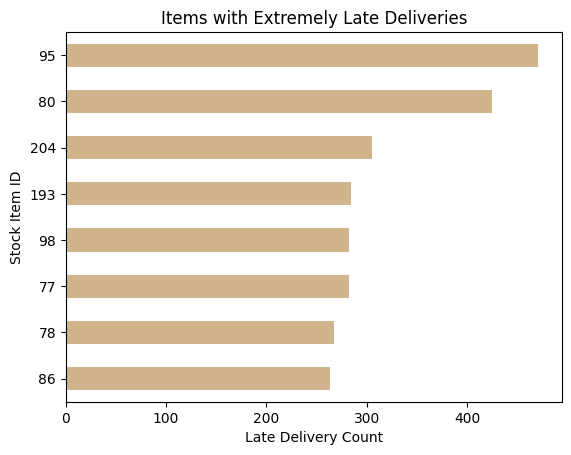

In [879]:
(df_late_items
    .head(8)
    .sort_values()
    .plot.barh(
        title='Items with Extremely Late Deliveries',
        xlabel='Late Delivery Count',
        ylabel='Stock Item ID',
        color='Tan',
    )
);

## Initial  Summary Analysis

**Discovered Performance Driver:**  
> Eight stock items account for all extremely late deliveries:  
> * ids  `95`, `80`, `98`, `86`, `193`, `204`, `78`, `77`

**Secondary Question:**  
> What is special about these eight stock items that causes such long delivery delays?

In [837]:
# Isolate the problem items and look for clustering in other columns
problem_items = [95, 80, 98, 86, 193, 204, 78, 77]
df_problems = df[df['stock_item_id'].isin(problem_items)]

# Test hypotheses
print('\nLate Deliveries by Package Type')
print(df_problems.groupby('package_type_name', observed=False).size().sort_values(ascending=False))

print('\nLate Deliveries by Sales Territory')
print(df_problems.groupby('sales_territory', observed=False).size().sort_values(ascending=False))

print('\nLate Deliveries by Avg Qty per Line')
print(df_problems.groupby('avg_qty_per_line', observed=False).size().sort_values(ascending=False).head(30))


Late Deliveries by Package Type
package_type_name
Each      5150
Bag          0
Packet       0
Pair         0
dtype: int64

Late Deliveries by Sales Territory
sales_territory
Southeast         1184
Mideast            716
Southwest          714
Plains             687
Great Lakes        630
Far West           581
Rocky Mountain     344
New England        218
External            76
dtype: int64

Late Deliveries by Avg Qty per Line
avg_qty_per_line
60.0     597
48.0     584
72.0     498
36.0     484
24.0     432
96.0     261
12.0     242
84.0     202
120.0    129
40.0      95
30.0      87
20.0      78
50.0      78
108.0     66
144.0     65
10.0      52
168.0     29
80.0      28
192.0     20
15.0      17
90.0      15
70.0      13
26.0      12
17.0      11
9.0       11
240.0     11
7.0       11
8.0       10
11.0      10
7.5        9
dtype: int64


## Diagnostic Drill-Down

**Root Cause:**
</br> - All 5,150 unacceptably late deliveries — 100% — involve stock items sold in "Each" units.

**Evidence:**
</br> - `package_type_name == "Each"`: **5,150 unacceptably late delivery lines**
</br> - All other types (`Bag`, `Packet`, `Pair`): **0 unacceptably late delivery lines**
</br> - No territorial concentration (Southeast leads, but doesn't indicate anomaly)

**Secondary Question Answered:**
</br> - What is special about these eight stock items?
</br> --> They are all sold in "Each" units — so "Each" packaging causes 100% of unacceptably late deliveries.

## Recommended Actions  
  
1. Audit 8 SKUs for supplier lead time, inventory policy, forecasting
</br> - Owner: Supply Chain
</br> - Impact: Eliminates 100% of unacceptably late deliveries
2. Review "Each" packaging — special handling? Fragility?
</br> - Owner: Logistics
</br> - Impact: Prevents future issues
3. Add UOM-based SLA for "Each" items
</br> - Owner: Operations
</br> - Impact: Proactive monitoring

---

**Business Impact**:  
> * Fixing these 8 items means zero unacceptably late deliveries  
> * ROI: Immediate, measurable, sustainable